# Example 1: Introducing the Water Table Fluctuation (WTF) Method

*R.A. Collenteur, July 2025*

This notebook is meant to introduce the WTFPy package and learn how to use it to estimate groundwater recharge from the groundwater table fluctuations. 

The general procedure to estimate the recharge is as follows:

0. Import Python packages
1. Load the head data
2. Extract recharge events
3. Estimate recharge
4. Analyze the results

## 0. Import Python packages

Here we import theb necessary Python packages and use the `show_versions` function to print the installed dependencies of `wft_py`. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import wtf_py as wtf

wtf.show_versions()

wtf_py: 0.1.0
pandas: 2.3.1
numpy: 2.3.1
scipy: 1.16.0
matplotlib: 3.10.3


## 1. Load the data

The first step is to load the water table data and rainfall data that we want to use to estimate the groundwater recharge for. Here we use the groundwater table data from the hydrological research station "Wagna" in southeastern Austria. This data was also used to to estimate groundwater recharge from groundwater level data in an earlier study ([Collenteur et al. 2021](https://hess.copernicus.org/articles/25/2931/2021/)).

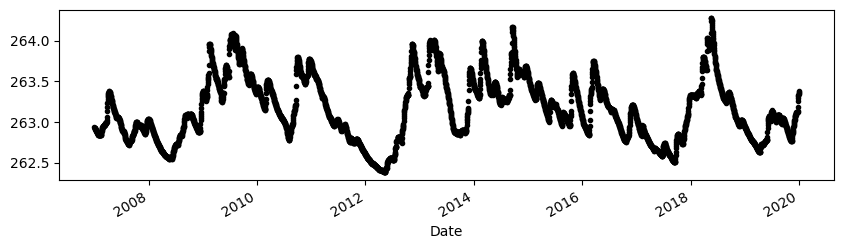

In [2]:
wt = (
    pd.read_csv(
        "data/data_wagna/head_wagna.csv", index_col=0, parse_dates=True, skiprows=2
    )
    .squeeze()
    .resample("D")
    .mean()
).loc["2007":]

wt = wt.dropna()
wt.plot(marker=".", linestyle=" ", color="k", figsize=(10, 2.5));

## 2. Create a first Model

We can now develop a simple model to estimate the groundwater recharge. In this first example we test a simple model were the absolute positive rises are computed and used to compute the recharge. The first step is to create a `Model` instance and provide it with the water table data. Next, using an estimate of the specific yield (`sy`), we can can the `estimate_recharge` method. 

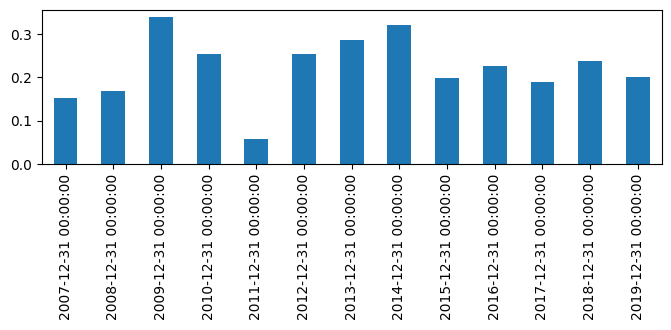

In [3]:
ml1 = wtf.Model(wt, name="Wagna")

sy = 0.144  # Specific yield estimate

# Estimate the groundwater recharge
r1 = ml1.estimate_recharge(rise_rule="rises", sy=sy)

# Plot the results as annual sums
r1.resample("YE").sum().plot(kind="bar", figsize=(8, 2));

## Exploring the `Model` object

Great, we now have a recharge estimate. But how did WTFpy get there? Let's explore the `Model` object a bit more to better understand what is going on under the hood and how to check on the internals. For those interested, a good idea is probably to check out the `ml.estimate_recharge` method. Here we'll walk you through the basic steps.

### Step 1. Determine recharge event intervals

The first step is to determine when the recharge events occurred. Depending on the method, only the periods with groundwater table rises or the entire time series may be considered. This is determined by the `rise_rule` argument, which defaults to only the rises. The event intervals are stored as in the model attibute `ml.events` as an IntervalIndex and can be obtained as follows:

In [4]:
# Method used to get the recharge events
# ml1.get_recharge_event_intervals(wt)

ml1.events[:5]  # Only show the first five events

IntervalIndex([(2007-01-31 00:00:00, 2007-02-01 00:00:00],
               (2007-02-01 00:00:00, 2007-02-02 00:00:00],
               (2007-02-02 00:00:00, 2007-02-03 00:00:00],
               (2007-02-03 00:00:00, 2007-02-04 00:00:00],
               (2007-02-04 00:00:00, 2007-02-05 00:00:00]],
              dtype='interval[datetime64[ns], right]')

### Step 2. Determine the rises

In the second step the water table rises are determined from the water table data. This is, depending on the chosen method, the most elaborate step. In the previously created model `ml1`, the rises are simply computed as the difference in the water table at the beginning and end of the recharge event period. If a Master Recession Curve (MCR) is used, this step is a bit more complicated (but not that much). The rises are stored in the `ml.rises` attribute and can be obtained as follows.

In [5]:
ml1.rises[:5]  # Only show the first five rises

(2007-01-31 00:00:00, 2007-02-01 00:00:00]    0.000260
(2007-02-01 00:00:00, 2007-02-02 00:00:00]    0.000431
(2007-02-02 00:00:00, 2007-02-03 00:00:00]    0.000817
(2007-02-03 00:00:00, 2007-02-04 00:00:00]    0.000983
(2007-02-04 00:00:00, 2007-02-05 00:00:00]    0.000341
dtype: float64

Note that the index is the same IntervalIndex as `ml1.events`. 

### Step 3. Estimate recharge

 The final step is to compute the recharge by multiplying the rises by the specific yield. Finally, we can make a summary plot using the `ml.plot` functions as follows:

/Users/raoulcollenteur/Github/wtf_py/wtf_py/model.py:228: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  axs[0].plot([interval.left, interval.right],


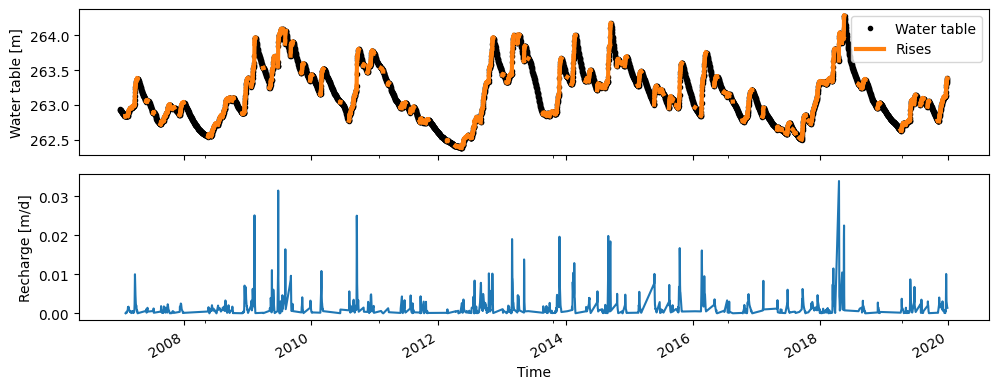

In [6]:
ml1.plot(figsize=(10, 4));

## Model with only rises and MCR

<Axes: >

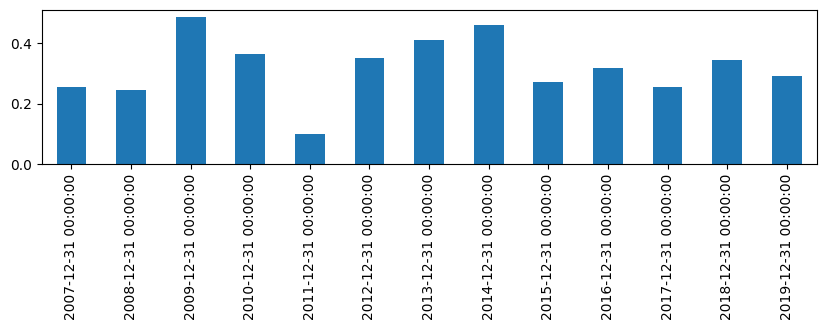

In [7]:
ml2 = wtf.Model(wt, name="Wagna", mcr=wtf.MCR())
ml2.mcr.fit_mcr(wt)

# Estimate the groundwater recharge
r2 = ml2.estimate_recharge(rise_rule="rises", sy=sy)
r2.resample("YE").sum().plot(kind="bar", figsize=(10, 2))

### Check the fitted MCR

We now automatically fitted the MCR and used it to extrapolate the water table during an event period. We can use the `MCR.plot` method to check the results visually. 

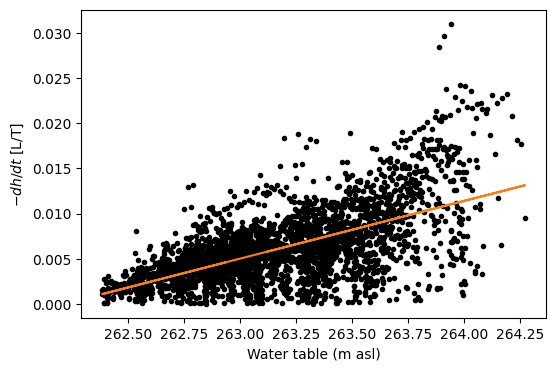

In [8]:
ml2.mcr.plot(wt);

## Model with rises and falls and MCR

<Axes: >

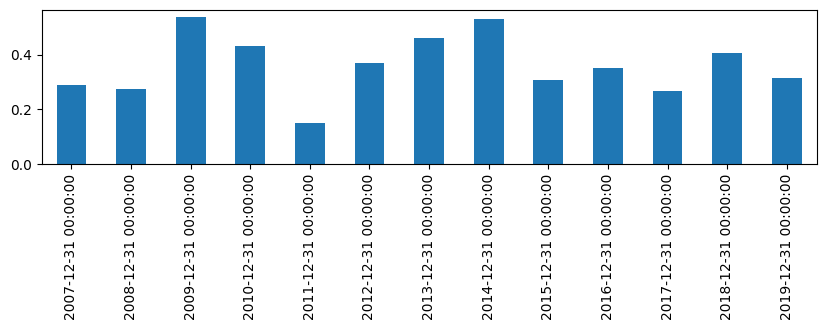

In [9]:
ml3 = wtf.Model(wt, name="Wagna", mcr=wtf.MCR())
ml3.mcr.fit_mcr(wt)

# Estimate the groundwater recharge
r3 = ml3.estimate_recharge(rise_rule="both", sy=sy)
r3.resample("YE").sum().plot(kind="bar", figsize=(10, 2))

/var/folders/hs/1j43d1k53k38dlwr99tmgf780000gn/T/ipykernel_63169/3866246539.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  r.plot(ax=ax, subplots=True)


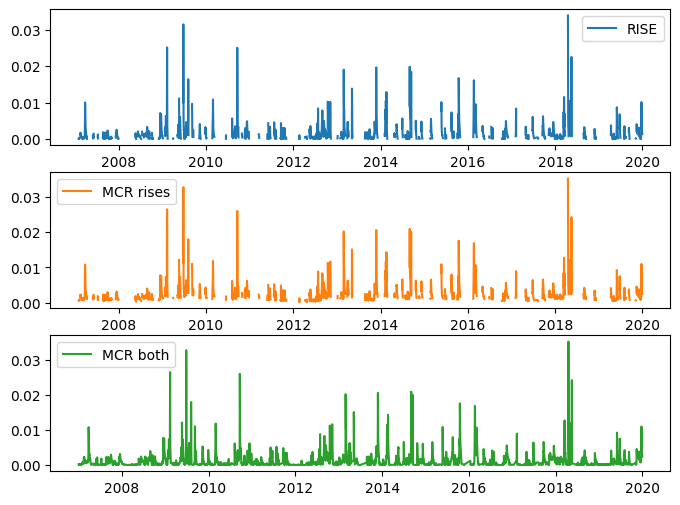

In [10]:
_, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

r = pd.concat([r1, r2, r3], axis=1)
r.columns = ["RISE", "MCR rises", "MCR both"]
r.plot(ax=ax, subplots=True)
ax.set_ylabel("Recharge (m/d)");

### Or annual sums ...


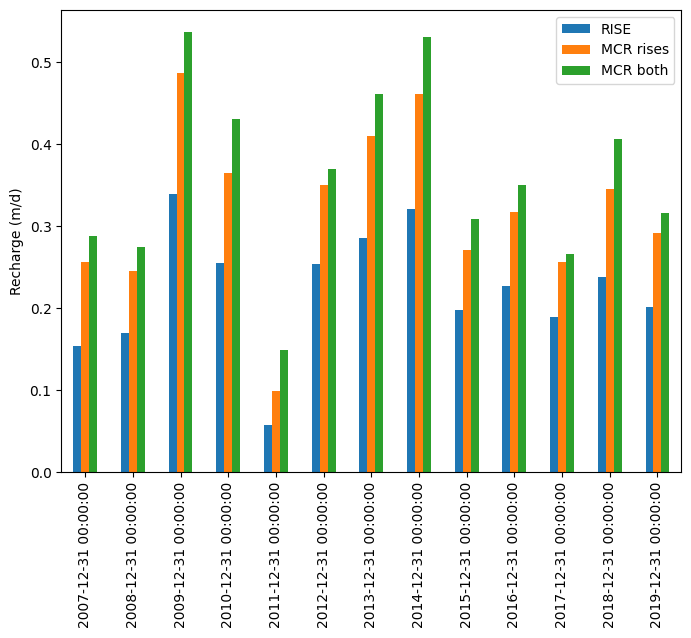

In [11]:
_, ax = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

r = pd.concat([r1, r2, r3], axis=1)
r.columns = ["RISE", "MCR rises", "MCR both"]
r.resample("YE").sum().plot(ax=ax, kind="bar")
ax.set_ylabel("Recharge (m/d)");


## Theory




$R = S_y \frac{\Delta h}{\Delta T}$

where $\Delta H$ is the head change over the time period $\Delta T$, and $S_y$ is the specific yield. The specific yield needs to be provided by the user, preferably including uncertainty estimates. The changes in head over time are estimated using one of the methods available from `wtf_py`. 

**Prerequisites / Assumptions**

- Water table fluctuations are the result of variations in groundwater recharge.
- A good estimate of the specific yield is available.
- ...


